

# Personalized Contrastive Learning in Dysarthric Word Recognition

## Baseline non-Contrastive Models

This notebook is meant to contain the code used in James Dana's final project for the class DATA-0297 in Spring 2025.


## Goals
- How does Wav2Vec2 do on our TORGO data subset without contrastive learning?

In [ ]:
from google.colab import drive

from transformers import Wav2Vec2Model, Wav2Vec2Processor
import torch

import pandas as pd
import numpy as np

import time
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import random

In [ ]:
# Mount Drive.
drive.mount('/content/drive')

# Load only the audio files we need.
df_torgo = pd.read_parquet("/content/drive/MyDrive/torgo_data/flat_torgo.parquet")
# Load the train/holdout metadata.
df_train = pd.read_csv("/content/drive/MyDrive/torgo_data/train_data.csv")
df_test_gen = pd.read_csv("/content/drive/MyDrive/torgo_data/holdout_gen.csv")
df_test_per = pd.read_csv("/content/drive/MyDrive/torgo_data/holdout_per.csv")
2
print(df_train.shape)
print(df_test_gen.shape)
print(df_test_per.shape)

Mounted at /content/drive
(314, 6)
(170, 6)
(292, 6)


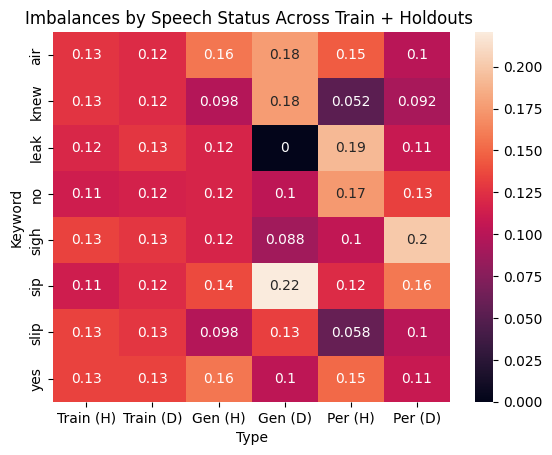

In [ ]:
# for df_train, df_test_gen, df_test_per, get the distribution of keywords by speech status.
# and concatenated into a single table.
# set up a multiplot
#axs, fig = plt.subplots(1, 3, figsize=(15, 5))


df_tr_count = df_train.groupby(['speech_status','transcription']).size().reset_index(name='count')
df_tr_count['Type'] = df_tr_count['speech_status'].apply(lambda x: f"Train ({x[0].capitalize()})")
df_tr_count['Keyword'] = df_tr_count['transcription'].copy()
df_gen_count = df_test_gen.groupby(['speech_status','transcription']).size().reset_index(name='count')
df_gen_count['Type'] = df_gen_count['speech_status'].apply(lambda x: f"Gen ({x[0].capitalize()})")
df_gen_count['Keyword'] = df_gen_count['transcription'].copy()
df_per_count = df_test_per.groupby(['speech_status','transcription']).size().reset_index(name='count')
df_per_count['Type'] = df_per_count['speech_status'].apply(lambda x: f"Per ({x[0].capitalize()})")
df_per_count['Keyword'] = df_per_count['transcription'].copy()

# concatenate
df_concat = pd.concat([df_tr_count, df_gen_count, df_per_count])
df_concat = df_concat.drop(columns=['speech_status']).reset_index(drop=True)
df_pivot = df_concat.pivot(index='Keyword', columns='Type', values='count').fillna(0)

# normalize the columns by columns, not whole data
df_pivot = df_pivot.div(df_pivot.sum(axis=0), axis=1)
df_pivot = df_pivot[['Train (H)', 'Train (D)', 'Gen (H)', 'Gen (D)', 'Per (H)', 'Per (D)']]

# now let's plot that heatmp
sns.heatmap(df_pivot,annot=True)
plt.title("Imbalances by Speech Status Across Train + Holdouts ")
plt.savefig('/content/drive/MyDrive/torgo_data/imbalance_heatmap.png', dpi=300)
plt.show()

In [ ]:
# What's the optimal max_length?
max_length=60000
print(f"For truncation/padding cutoff {max_length}:")
print(f"   {round(100*np.mean(df_torgo['audio_array_length']<max_length))}% of audio files aren't truncated")

For truncation/padding cutoff 60000:
   96% of audio files aren't truncated


## Useful commands

In [ ]:
def get_memory_report():
    if torch.cuda.is_available():
      print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
      total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
      allocated_memory = torch.cuda.memory_allocated(0) / 1024**3
      reserved_memory = torch.cuda.memory_reserved(0) / 1024**3
      free_memory = total_memory - allocated_memory - (reserved_memory - allocated_memory)
      print(f"Total GPU Memory: {total_memory:.2f} GB")
      print(f"Allocated GPU Memory: {allocated_memory:.2f} GB")
      print(f"Reserved GPU Memory: {reserved_memory:.2f} GB")
      print(f"Free GPU Memory: {free_memory:.2f} GB")
    else:
      print("CUDA not available")

In [ ]:
model_detail_dict = {
    '0': 'Frozen Wav2Vec2 => KNN',
    '1': 'Frozen Wav2Vec2 => Classifier',
    '2': 'Frozen Wav2Vec2 => Conv1D'
}
def eval_embeddings_cm(df, param_dict=None, model_type="",itr_type=""):
    """
    Evaluate embeddings for accuracy, weighted f1, confusion matrix
    Evaluate perfomance stratified by speech status.
    Args:
        df (pd.DataFrame)             df containing predictions
        param_dict (dict):            (optional) Dictionary w/ model hyperparameters
    """
    # Extract Training Data
    df_tr = df[df['d_type']=='train'].reset_index(drop=True)
    y_tr = df_tr['y_true']
    y_tr_dys = y_tr[df_tr['status'] == 'dysarthria']
    y_tr_non_dys = y_tr[df_tr['status'] == 'healthy']
    y_hat_tr  = df_tr['y_hat']
    y_hat_tr_dys = y_hat_tr[df_tr['status'] == 'dysarthria']
    y_hat_tr_non_dys = y_hat_tr[df_tr['status'] == 'healthy']

    # Extract Gen Data
    df_per = df[df['d_type']=='holdout-per'].reset_index(drop=True)
    y_per = df_per['y_true']
    y_per_dys = y_per[df_per['status'] == 'dysarthria']
    y_per_non_dys = y_per[df_per['status'] == 'healthy']
    y_hat_per = df_per['y_hat']
    y_hat_per_dys = y_hat_per[df_per['status'] == 'dysarthria']
    y_hat_per_non_dys = y_hat_per[df_per['status'] == 'healthy']

    # Extract Gen Data
    df_gen = df[df['d_type']=='holdout-gen'].reset_index(drop=True)
    y_gen = df_gen['y_true']
    y_gen_dys = y_gen[df_gen['status'] == 'dysarthria']
    y_gen_non_dys = y_gen[df_gen['status'] == 'healthy']
    y_hat_gen = df_gen['y_hat']
    y_hat_gen_dys = y_hat_gen[df_gen['status'] == 'dysarthria']
    y_hat_gen_non_dys = y_hat_gen[df_gen['status'] == 'healthy']

    # set up minidfs
    df_results_tr_all = pd.DataFrame({
        'y_true': y_tr,
        'y_hat': y_hat_tr,
        'status': 'all',
        'd_type': 'train'
    })
    df_results_tr_dys = pd.DataFrame({
        'y_true': y_tr_dys,
        'y_hat': y_hat_tr_dys,
        'status': 'dysarthria',
        'd_type': 'train'
    })
    df_results_tr_non_dys = pd.DataFrame({
        'y_true': y_tr_non_dys,
        'y_hat': y_hat_tr_non_dys,
        'status': 'healthy',
        'd_type': 'train'
    })
    df_results_gen_all = pd.DataFrame({
        'y_true': y_gen,
        'y_hat': y_hat_gen,
        'status': 'all',
        'd_type': 'holdout-gen'
    })
    df_results_gen_dys = pd.DataFrame({
        'y_true': y_gen_dys,
        'y_hat': y_hat_gen_dys,
        'status': 'dysarthria',
        'd_type': 'holdout-gen'
    })
    df_results_gen_non_dys = pd.DataFrame({
        'y_true': y_gen_non_dys,
        'y_hat': y_hat_gen_non_dys,
        'status': 'healthy',
        'd_type': 'holdout-gen'
    })
    df_results_per_all = pd.DataFrame({
        'y_true': y_per,
        'y_hat': y_hat_per,
        'status': 'all',
        'd_type': 'holdout-per'
    })
    df_results_per_dys = pd.DataFrame({
        'y_true': y_per_dys,
        'y_hat': y_hat_per_dys,
        'status': 'dysarthria',
        'd_type': 'holdout-per'
    })
    df_results_per_non_dys = pd.DataFrame({
        'y_true': y_per_non_dys,
        'y_hat': y_hat_per_non_dys,
        'status': 'healthy',
        'd_type': 'holdout-per'
    })
    # concatentate
    df_concat = pd.concat([df_results_tr_all, df_results_tr_dys, df_results_tr_non_dys,
                           df_results_gen_all, df_results_gen_dys, df_results_gen_non_dys,
                           df_results_per_all, df_results_per_dys, df_results_per_non_dys])
    # Reshape for confusion matrix plot.
    df_concat['status'] = pd.Categorical(df_concat['status'], categories=['all','healthy', 'dysarthria'], ordered=True)
    df_concat['d_type'] = pd.Categorical(df_concat['d_type'], categories=['train', 'holdout-gen', 'holdout-per'], ordered=True)
    plot_classes = ['sip','air','yes','sigh','no','knew','slip','leak']

    # define cm plot
    def cmplot(x, y, **kwargs):
        cm = confusion_matrix(y,x,labels = plot_classes)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # plot confusion matrix
        cmap = sns.color_palette("Blues", as_cmap=True)
        plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
        tick_marks = np.arange(len(plot_classes))
        plt.xticks(tick_marks, plot_classes, rotation=45, ha="right")
        plt.yticks(tick_marks, plot_classes)

    plt.figure(figsize=(15, 15))
    g = sns.FacetGrid(df_concat,row="status",col="d_type",sharex=False,sharey=False)
    g.map(cmplot,"y_hat","y_true")
    #g.set_titles("{col_name} data ({row_name})")
    plt.suptitle(f"{model_detail_dict[model_type]}-{itr_type}: Confusion Matrices")

    # set titles w/ scores
    for i, row_val in enumerate(g.row_names):
      for j, col_val in enumerate(g.col_names):
        ax = g.axes[i,j]
        df_facet = df_concat[(df_concat['status'] == row_val) & (df_concat['d_type'] == col_val)]
        acc = round(accuracy_score(df_facet['y_true'], df_facet['y_hat']),4)
        f1 = round(f1_score(df_facet['y_true'], df_facet['y_hat'], average='weighted'),4)
        title = f"{col_val} data ({row_val})\nAcc: {acc}, F1: {f1}"
        ax.set_title(title)
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/torgo_data/BS_M{model_type}_I{itr_type}_heatmap.png', dpi=300)
    plt.show()


In [ ]:
get_memory_report()

# Load model and processor (base model, no CTC head)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
model.eval()  # Set to eval mode

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Move model to GPU
model = model.to(device)

get_memory_report()

CUDA Device Name: Tesla T4
Total GPU Memory: 14.74 GB
Allocated GPU Memory: 0.00 GB
Reserved GPU Memory: 0.00 GB
Free GPU Memory: 14.74 GB


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Using device: cuda
CUDA Device Name: Tesla T4
Total GPU Memory: 14.74 GB
Allocated GPU Memory: 0.35 GB
Reserved GPU Memory: 0.39 GB
Free GPU Memory: 14.35 GB


In [ ]:
!nvidia-smi

Tue May  6 22:55:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P0             33W /   70W |     894MiB /  15360MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Using Frozen Wav2Vec2, Embed audio files.

In [ ]:
print(max_length)
# embed the data
batch_size = 4  # Set batch size depending on your available GPU memory
start_time = time.time()

all_pooled_embeddings = []
all_unpooled_embeddings = []
batch_speech_raw = []
batch_speech_padded = []
path_list = []

max_length = 60000

for ii in tqdm(range(len(df_torgo))): # iterate over parquet
    speech = df_torgo.loc[ii,'audio_array']
    path = df_torgo.loc[ii,'audio_path']
    batch_speech_raw.append(speech) # get batch
    path_list.append(path)

    # there were issues padding/truncating so I've got to do it myself.
    if len(batch_speech_raw) == batch_size or ii == len(df_torgo) - 1:
        for raw_speech in batch_speech_raw:
            current_length = len(raw_speech)
            if current_length > max_length:
                padded_speech = raw_speech[:max_length]  # Truncate
            elif current_length < max_length:
                padding_needed = max_length - current_length
                padded_speech = np.pad(raw_speech, (0, padding_needed), 'constant') # Pad with zeros
            else:
                padded_speech = raw_speech
            batch_speech_padded.append(padded_speech)
        # run processor
        inputs = processor(batch_speech_padded, sampling_rate=16000,max_length=max_length,padding=True,truncation=True,return_tensors="pt") # No padding or max_length here
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Process embeddings
        with torch.no_grad():
            hidden_states = model(**inputs).last_hidden_state

        # Pooled embeddings
        pooled = hidden_states.mean(dim=1).squeeze()
        all_pooled_embeddings.append(pooled.cpu())
        del pooled

        # Unpooled embeddings
        all_unpooled_embeddings.append(hidden_states.cpu())
        del hidden_states
        del inputs

        # Reset the batch.
        batch_speech_raw = []
        batch_speech_padded = []

end_time = time.time()
total_time = end_time - start_time
total_samples = len(all_pooled_embeddings) * batch_size if len(df_torgo) > batch_size else len(df_torgo)
print(f"\nEmbedded approximately {total_samples} audio files in {total_time:.2f} seconds.")
print(f"Avg time per file: {total_time / total_samples:.4f} seconds")

pooled_embedding_matrix = torch.cat(all_pooled_embeddings).numpy()
unpooled_embedding_list = [embedding.numpy() for embedding in all_unpooled_embeddings]

print("\nPooled Embedding Matrix Shape:", pooled_embedding_matrix.shape)
print("Number of Unpooled Embedding Batches:", len(unpooled_embedding_list))
print("Shape of First Unpooled Embedding Batch:", unpooled_embedding_list[0].shape)

60000


100%|██████████| 776/776 [00:14<00:00, 52.69it/s]


Embedded approximately 776 audio files in 14.73 seconds.
Avg time per file: 0.0190 seconds

Pooled Embedding Matrix Shape: (776, 768)
Number of Unpooled Embedding Batches: 194
Shape of First Unpooled Embedding Batch: (4, 187, 768)


In [ ]:
# merge embeddings to the datasets slices.
df_embeds_pool = pd.DataFrame({
    'path': path_list,
    'embedding': pooled_embedding_matrix.tolist()
})
df_train_em_pool = pd.merge(df_train, df_embeds_pool, on='path', how='left')
df_test_gen_em_pool = pd.merge(df_test_gen, df_embeds_pool, on='path', how='left')
df_test_per_em_pool = pd.merge(df_test_per, df_embeds_pool, on='path', how='left')

## Baseline Model 1: Cold Wav2Vec2 => KNN

In [ ]:

def eval_embeddings(df_param):
  # 0. Load Metadata
  df_train = pd.read_csv("/content/drive/MyDrive/torgo_data/train_data.csv")
  df_test_gen = pd.read_csv("/content/drive/MyDrive/torgo_data/holdout_gen.csv")
  df_test_per = pd.read_csv("/content/drive/MyDrive/torgo_data/holdout_per.csv")
  df_train = pd.merge(df_train, df_param, on='path', how='left')
  df_test_gen = pd.merge(df_test_gen, df_param, on='path', how='left')
  df_test_per = pd.merge(df_test_per, df_param, on='path', how='left')

  # 1. Set up x/y for eval, training
  x_tr = np.vstack(df_train['embedding'].values)  # Stack all embeddings into a matrix (shape: n_samples, embedding_dim)
  y_tr = df_train['transcription']
  x_gen = np.vstack(df_test_gen['embedding'].values)  # Stack all embeddings into a matrix (shape: n_samples, embedding_dim)
  y_gen = df_test_gen['transcription']
  x_per = np.vstack(df_test_per['embedding'].values)  # Stack all embeddings into a matrix (shape: n_samples, embedding_dim)
  y_per = df_test_per['transcription']

  # 2. fit to train.
  knn = KNeighborsClassifier(n_neighbors=8) # 9 words
  knn.fit(x_tr, y_tr)

  # 3. predict on train/gen/per
  y_hat_tr  = knn.predict(x_tr)
  y_hat_gen = knn.predict(x_gen)
  y_hat_per = knn.predict(x_per)

  # 4. get subsets
  y_tr_dys = y_tr[df_train['speech_status'] == 'dysarthria']
  y_tr_non_dys = y_tr[df_train['speech_status'] == 'healthy']
  y_gen_dys = y_gen[df_test_gen['speech_status'] == 'dysarthria']
  y_gen_non_dys = y_gen[df_test_gen['speech_status'] == 'healthy']
  y_per_dys = y_per[df_test_per['speech_status'] == 'dysarthria']
  y_per_non_dys = y_per[df_test_per['speech_status'] == 'healthy']
  y_hat_tr_dys = y_hat_tr[df_train['speech_status'] == 'dysarthria']
  y_hat_tr_non_dys = y_hat_tr[df_train['speech_status'] == 'healthy']
  y_hat_gen_dys = y_hat_gen[df_test_gen['speech_status'] == 'dysarthria']
  y_hat_gen_non_dys = y_hat_gen[df_test_gen['speech_status'] == 'healthy']
  y_hat_per_dys = y_hat_per[df_test_per['speech_status'] == 'dysarthria']
  y_hat_per_non_dys = y_hat_per[df_test_per['speech_status'] == 'healthy']

  # Get accuracies
  acc_tr = accuracy_score(y_tr, y_hat_tr)
  acc_tr_dys = accuracy_score(y_tr_dys, y_hat_tr_dys)
  acc_tr_non_dys = accuracy_score(y_tr_non_dys, y_hat_tr_non_dys)
  acc_gen = accuracy_score(y_gen, y_hat_gen)
  acc_gen_dys = accuracy_score(y_gen_dys, y_hat_gen_dys)
  acc_gen_non_dys = accuracy_score(y_gen_non_dys, y_hat_gen_non_dys)
  acc_per = accuracy_score(y_per, y_hat_per)
  acc_per_dys = accuracy_score(y_per_dys, y_hat_per_dys)
  acc_per_non_dys = accuracy_score(y_per_non_dys, y_hat_per_non_dys)

  f1_tr = f1_score(y_tr, y_hat_tr, average="weighted")
  f1_tr_dys = f1_score(y_tr_dys, y_hat_tr_dys, average="weighted")
  f1_tr_non_dys = f1_score(y_tr_non_dys, y_hat_tr_non_dys, average="weighted")
  f1_gen = f1_score(y_gen, y_hat_gen, average="weighted")
  f1_gen_dys = f1_score(y_gen_dys, y_hat_gen_dys, average="weighted")
  f1_gen_non_dys = f1_score(y_gen_non_dys, y_hat_gen_non_dys, average="weighted")
  f1_per = f1_score(y_per, y_hat_per, average="weighted")
  f1_per_dys = f1_score(y_per_dys, y_hat_per_dys, average="weighted")
  f1_per_non_dys = f1_score(y_per_non_dys, y_hat_per_non_dys, average="weighted")
  # print something i can paste into markdown to make a table.
  # Ideal structure:
  #
  print("| Dataset      | Subset     | Accuracy     | F1-Score  |")
  print("|--------------|------------|--------------|-----------|")
  print(f"| **Train**   | All        | {round(acc_tr,4)}       | {round(f1_tr,4)}        |")
  print(f"|            | Dysarthria | {round(acc_tr_dys,4)}       | {round(f1_tr_dys,4)}   |")
  print(f"|              | Healthy    | {round(acc_tr_non_dys,4)}       | {round(f1_tr_non_dys,4)}     |")
  print(f"| **Hold-Gen** | All        | {round(acc_gen,4)}       | {round(f1_gen,4)}     |")
  print(f"|              | Dysarthria | {round(acc_gen_dys,4)}       | {round(f1_gen_dys,4)}     |")
  print(f"|              | Healthy    | {round(acc_gen_non_dys,4)}       | {round(f1_gen_non_dys,4)}     |")
  print(f"| **Hold-Per** | All        | {round(acc_per,4)}       | {round(f1_per,4)}     |")
  print(f"|              | Dysarthria | {round(acc_per_dys,4)}       | {round(f1_per_dys,4)}     |")
  print(f"|              | Healthy    | {round(acc_per_non_dys,4)}       | {round(f1_per_non_dys,4)}     |")

  latex_table = r"\begin{table}[H]" \
  + r"\begin{tabular}{|l|c|c|c|}" + "\n" \
  + r"\hline" + "\n" \
  + r"\textbf{M: KNN} & " + "\n" \
  + r"\textbf{\begin{tabular}[c]{@{}c@{}}All\\ Speakers\end{tabular}} & " + "\n" \
  + r"\textbf{\begin{tabular}[c]{@{}c@{}}Dystharic\\ Speakers\end{tabular}} & " + "\n" \
  + r"\textbf{\begin{tabular}[c]{@{}c@{}}Healthy\\ Speakers\end{tabular}} \\ \hline"""  \
  + "\n" + r"\textbf{df\_train} " + f" & {round(f1_tr,4):.4f} & {round(f1_tr_dys,4):.4f} & {round(f1_tr_non_dys,4):.4f} \\\\" + r"\hline" \
  + "\n" + r"\textbf{df\_h\_per} " + f"& {round(f1_per,4):.4f} & {round(f1_per_dys,4):.4f} & {round(f1_per_non_dys,4):.4f} \\\\" + r"\hline" \
  + "\n" + r"\textbf{df\_h\_gen} " + f"& {round(f1_gen,4):.4f} & {round(f1_gen_dys,4):.4f} & {round(f1_gen_non_dys,4):.4f} \\\\" + r"\hline" \
  + "\n" + r"\end{tabular}" \
  + "\n" + r"\caption{Wav2Vec2/KNN Weighted F1 Scores}" \
  + "\n" + r"\end{table}"

  df_tr_data = pd.DataFrame({'y_true': y_tr.values,'y_hat': y_hat_tr,'status':df_train['speech_status'].values,'d_type':'train'})
  df_tr_data2 = pd.DataFrame({'y_true': y_tr.values,'y_hat': y_hat_tr,'status':'all','d_type':'train'})
  df_gen_data = pd.DataFrame({'y_true': y_gen.values,'y_hat': y_hat_gen,'status':df_test_gen['speech_status'].values,'d_type':'holdout-gen'})
  df_gen_data2 = pd.DataFrame({'y_true': y_gen.values,'y_hat': y_hat_gen,'status':'all','d_type':'holdout-gen'})
  df_per_data = pd.DataFrame({'y_true': y_per.values,'y_hat': y_hat_per,'status':df_test_per['speech_status'].values,'d_type':'holdout-per'})
  df_per_data2 = pd.DataFrame({'y_true': y_per.values,'y_hat': y_hat_per,'status':'all','d_type':'holdout-per'})
  df_data = pd.concat([df_tr_data, df_tr_data2, df_gen_data, df_gen_data2, df_per_data,df_per_data2])
  return df_data, latex_table

# Seed-setting has no influence here.
seed_val = 42
# set seeds
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

df_b1,table = eval_embeddings(df_embeds_pool)
print(table)


| Dataset      | Subset     | Accuracy     | F1-Score  |
|--------------|------------|--------------|-----------|
| **Train**   | All        | 0.4713       | 0.4602        |
|            | Dysarthria | 0.4419       | 0.43   |
|              | Healthy    | 0.507       | 0.4958     |
| **Hold-Gen** | All        | 0.3647       | 0.3308     |
|              | Dysarthria | 0.1912       | 0.1912     |
|              | Healthy    | 0.4804       | 0.4383     |
| **Hold-Per** | All        | 0.3219       | 0.3307     |
|              | Dysarthria | 0.3167       | 0.31     |
|              | Healthy    | 0.3256       | 0.3454     |
\begin{table}[H]\begin{tabular}{|l|c|c|c|}
\hline
\textbf{M: KNN} & 
\textbf{\begin{tabular}[c]{@{}c@{}}All\\ Speakers\end{tabular}} & 
\textbf{\begin{tabular}[c]{@{}c@{}}Dystharic\\ Speakers\end{tabular}} & 
\textbf{\begin{tabular}[c]{@{}c@{}}Healthy\\ Speakers\end{tabular}} \\ \hline
\textbf{df\_train}  & 0.4602 & 0.4300 & 0.4958 \\\hline
\textbf{df\_h\_per} & 0.3307

| Dataset      | Subset     | Accuracy     | F1-Score  |
|--------------|------------|--------------|-----------|
| **Train**   | All        | 0.4395       | 0.4219        |
|            | Dysarthria | 0.4128       | 0.3874   |
|              | Healthy    | 0.4718       | 0.4503     |
| **Hold-Gen** | All        | 0.3353       | 0.312     |
|              | Dysarthria | 0.2059       | 0.1924     |
|              | Healthy    | 0.4216       | 0.3916     |
| **Hold-Per** | All        | 0.3185       | 0.3134     |
|              | Dysarthria | 0.2417       | 0.2283     |
|              | Healthy    | 0.3721       | 0.3683     |

<ipython-input-6-cea9a18bf40d>:108: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<Figure size 1500x1500 with 0 Axes>

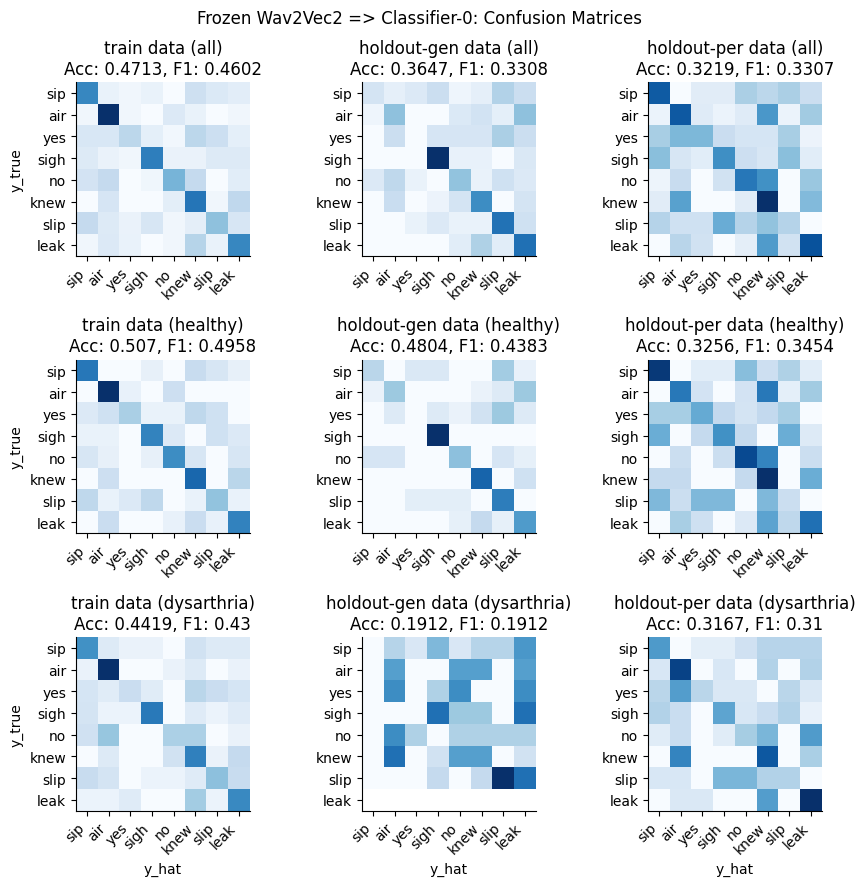

In [ ]:
eval_embeddings_cm(df_b1,model_type="1",itr_type="0")

## Baseline 2: Cold Wav2Vec2 => Classifier

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/torgo_data/train_data.csv")
df_test_gen = pd.read_csv("/content/drive/MyDrive/torgo_data/holdout_gen.csv")
df_test_per = pd.read_csv("/content/drive/MyDrive/torgo_data/holdout_per.csv")
df_train = pd.merge(df_train, df_embeds_pool, on='path', how='left')
df_test_gen = pd.merge(df_test_gen, df_embeds_pool, on='path', how='left')
df_test_per = pd.merge(df_test_per, df_embeds_pool, on='path', how='left')

# Convert to encoded values for model.
y_tr = label_encoder.fit_transform(df_train['transcription'])
print("Mapping (classes_ attribute):", label_encoder.classes_)
y_gen = label_encoder.transform(df_test_gen['transcription'])
y_per = label_encoder.transform(df_test_per['transcription'])


Mapping (classes_ attribute): ['air' 'knew' 'leak' 'no' 'sigh' 'sip' 'slip' 'yes']


### set up cross validation + hyperparameter search

In [ ]:
n_splits = 3  # or 3, depending on your data size

X_train_embeddings = np.array([np.array(x) for x in df_train['embedding']])
X_h_gen_embeddings = np.array([np.array(x) for x in df_test_gen['embedding']])
X_h_per_embeddings = np.array([np.array(x) for x in df_test_per['embedding']])

input_dim = X_train_embeddings.shape[-1]
num_classes = len(np.unique(y_tr))

def create_dense_model(input_dim, num_classes, l2_strength,hidden_size_d1):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.Dense(hidden_size_d1, activation='relu', kernel_regularizer=regularizers.L2(l2_strength)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(.3))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.L2(l2_strength)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

def run_model_hyperparameters(learning_rate,l2_strength,hidden_size_d1, X_tr, X_val, y_tr, y_val):
  tf.keras.backend.clear_session()

  # 1. Set up Model.
  input_dim = X_tr.shape[-1]
  num_classes = len(np.unique(y_tr))
  model = create_dense_model(input_dim, num_classes, l2_strength, hidden_size_d1)
  #model.summary()
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
  max_epochs = 25
  # 2. Fit Model.
  history = model.fit(X_tr, y_tr,
                      epochs=max_epochs,
                      validation_data=(X_val, y_val),
                      callbacks=[early_stopping],
                      verbose=0, batch_size=4)

  # 3. Store Validation performance
  score_tr = history.history['accuracy'][-1]
  score_va = history.history['val_accuracy'][-1]
  n_epochs = len(history.history['val_accuracy'])
  dict_scores = {
      'learning_rate': learning_rate,
      'l2_strength': l2_strength,
      'hidden_size': hidden_size_d1,
      'n_epochs': f"{n_epochs}/{max_epochs}",
      'score': score_va,
  }
  print(f"======> T:{round(score_tr,4)} V:{round(score_va,4)}")
  df_temp = pd.DataFrame(dict_scores,index=[0])
  return df_temp, history, score_tr, score_va

### Fit and Print Accuracy/F1

In [ ]:
from re import L
df_hyper = pd.DataFrame()

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
df_train['label_code'] = df_train['speech_status']+"_"+df_train['transcription']
label_encoder2 = LabelEncoder()
y_label_code = label_encoder2.fit_transform(df_train['transcription'])

history_dict = {}
learning_rates = [3e-5, 1e-4, 3e-4, 1e-3, 3e-3]
l2_strengths = [1e-6, 1e-5, 1e-4]
hidden_size_d1 = [32,64,128]

# get all possible combos of these 3 lists.
possible_hps = []
for lr in learning_rates:
  for l2 in l2_strengths:
    for h_size in hidden_size_d1:
      possible_hps.append((lr,l2,h_size))

# get random sample of them
random_search_hps = random.sample(possible_hps, 5)
print(random_search_hps)
l_fold = []
l_lr = []
l_l2 = []
l_score_va = []
l_score_tr = []

for rs_hps in random_search_hps:
    learning_rate, l2_strength, hidden_size_d1 = rs_hps
    print(f"[{learning_rate},{l2_strength},{hidden_size_d1}]")
    for ii, (train_index, val_index) in enumerate(skf.split(X_train_embeddings, y_label_code)):
        print(f"Fold {ii + 1}:")
        l_fold.append(ii+1)
        l_lr.append(learning_rate)
        l_l2.append(l2_strength)

        X_train_fold, X_val_fold = X_train_embeddings[train_index], X_train_embeddings[val_index]
        y_train_fold, y_val_fold = y_tr[train_index], y_tr[val_index]
        print(X_train_embeddings.shape,X_train_fold.shape,X_val_fold.shape,y_train_fold.shape,y_val_fold.shape)
        df_temp, history, acc_tr, va_tr = run_model_hyperparameters(
            learning_rate,l2_strength,hidden_size_d1,
            X_train_fold,X_val_fold,
            y_train_fold,y_val_fold)

        l_score_tr.append(acc_tr)
        l_score_va.append(va_tr)
        history_dict[f"Fold {ii+1}"] = history

# get the average performance by hyperparameters
df_hyperparam = pd.DataFrame({
    'fold': l_fold,
    'learning_rate': l_lr,
    'l2_strength': l_l2,
    'score_tr': l_score_tr,
    'score_va': l_score_va
})
df_hyperparam = df_hyperparam.groupby(['learning_rate','l2_strength']).mean().reset_index()
df_hyperparam = df_hyperparam.sort_values(by='score_va',ascending=False)
df_hyperparam.head()

[(0.003, 1e-05, 64), (3e-05, 0.0001, 64), (3e-05, 1e-06, 64), (0.0001, 0.0001, 128), (0.0001, 0.0001, 32)]
[0.003,1e-05,64]
Fold 1:
(314, 768) (209, 768) (105, 768) (209,) (105,)
======> T:0.311 V:0.381
Fold 2:
(314, 768) (209, 768) (105, 768) (209,) (105,)
======> T:0.2536 V:0.2286
Fold 3:
(314, 768) (210, 768) (104, 768) (210,) (104,)
======> T:0.2476 V:0.3173
[3e-05,0.0001,64]
Fold 1:
(314, 768) (209, 768) (105, 768) (209,) (105,)
======> T:0.1483 V:0.1429
Fold 2:
(314, 768) (209, 768) (105, 768) (209,) (105,)
======> T:0.1579 V:0.1524
Fold 3:
(314, 768) (210, 768) (104, 768) (210,) (104,)
======> T:0.1571 V:0.1442
[3e-05,1e-06,64]
Fold 1:
(314, 768) (209, 768) (105, 768) (209,) (105,)
======> T:0.1148 V:0.1714
Fold 2:
(314, 768) (209, 768) (105, 768) (209,) (105,)
======> T:0.1818 V:0.1524
Fold 3:
(314, 768) (210, 768) (104, 768) (210,) (104,)
======> T:0.1381 V:0.1058
[0.0001,0.0001,128]
Fold 1:
(314, 768) (209, 768) (105, 768) (209,) (105,)
======> T:0.1388 V:0.1429
Fold 2:
(314,

,learning_rate,l2_strength,fold,score_tr,score_va
3,0.00300,0.000010,2.0,0.270737,0.308944
2,0.00010,0.000100,2.0,0.162372,0.180113
1,0.00003,0.000100,2.0,0.154454,0.146490
0,0.00003,0.000001,2.0,0.144915,0.143193


Best Hyperparameters: Learning Rate: 0.003, Epochs: 50, l2 reg: 1e-05
Run #1: Seed=100


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,944 (202.91 KB)

 Trainable params: 51,752 (202.16 KB)

 Non-trainable params: 192 (768.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


<ipython-input-5-cea9a18bf40d>:108: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<Figure size 1500x1500 with 0 Axes>

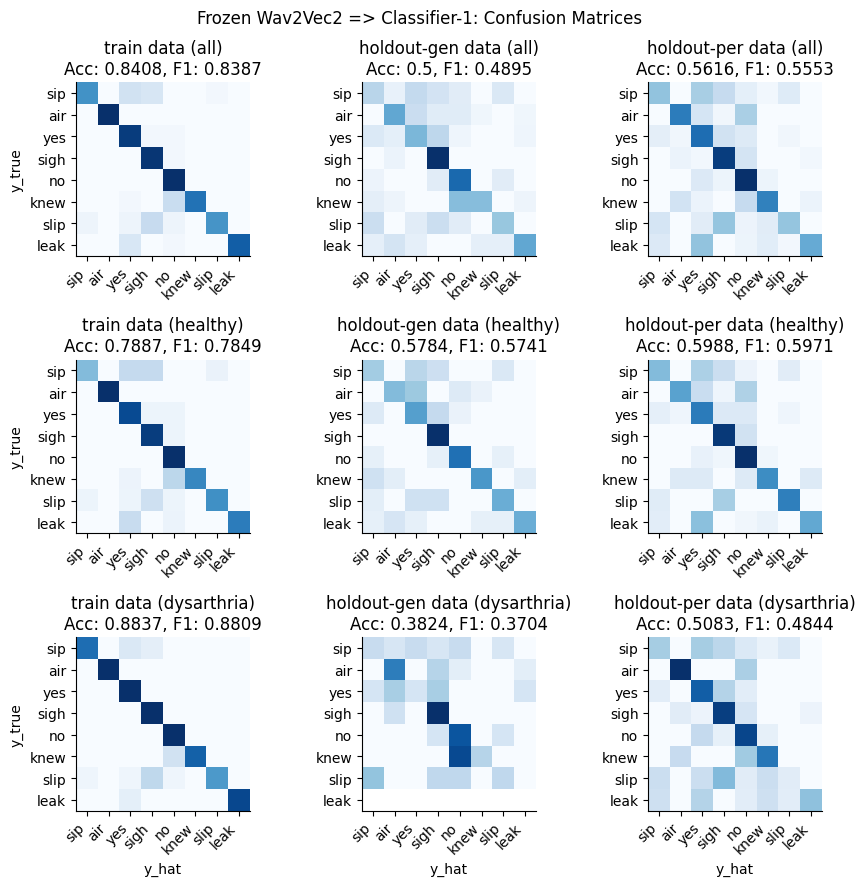

Run #2: Seed=200


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,944 (202.91 KB)

 Trainable params: 51,752 (202.16 KB)

 Non-trainable params: 192 (768.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


<ipython-input-5-cea9a18bf40d>:108: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<Figure size 1500x1500 with 0 Axes>

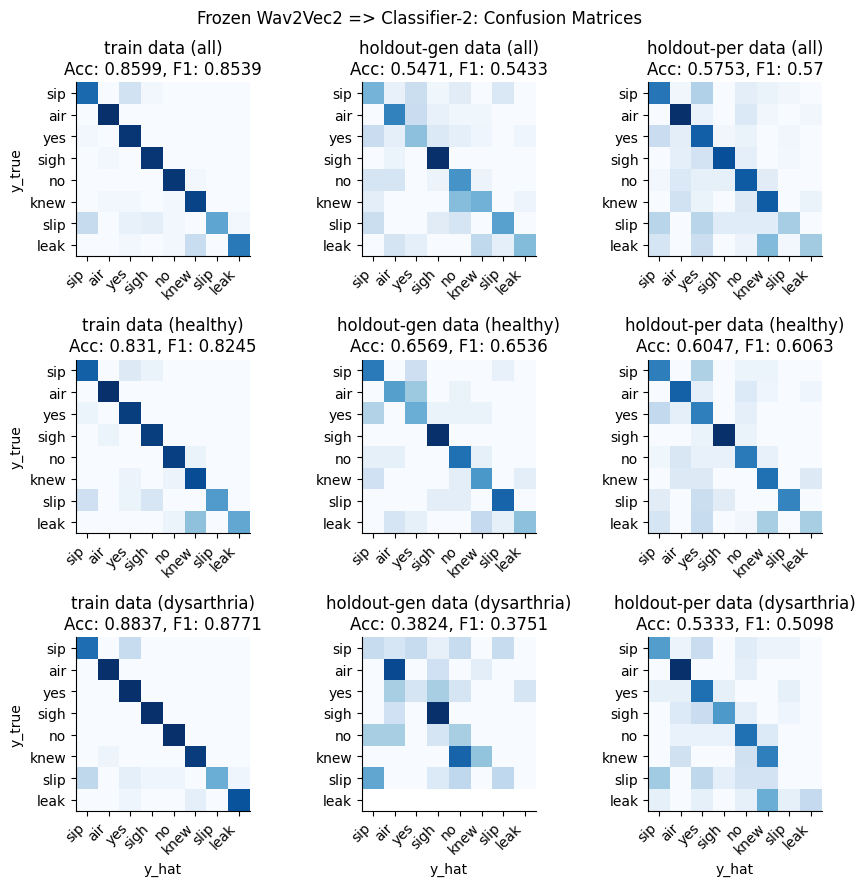

Run #3: Seed=300


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,944 (202.91 KB)

 Trainable params: 51,752 (202.16 KB)

 Non-trainable params: 192 (768.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


<ipython-input-5-cea9a18bf40d>:108: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<Figure size 1500x1500 with 0 Axes>

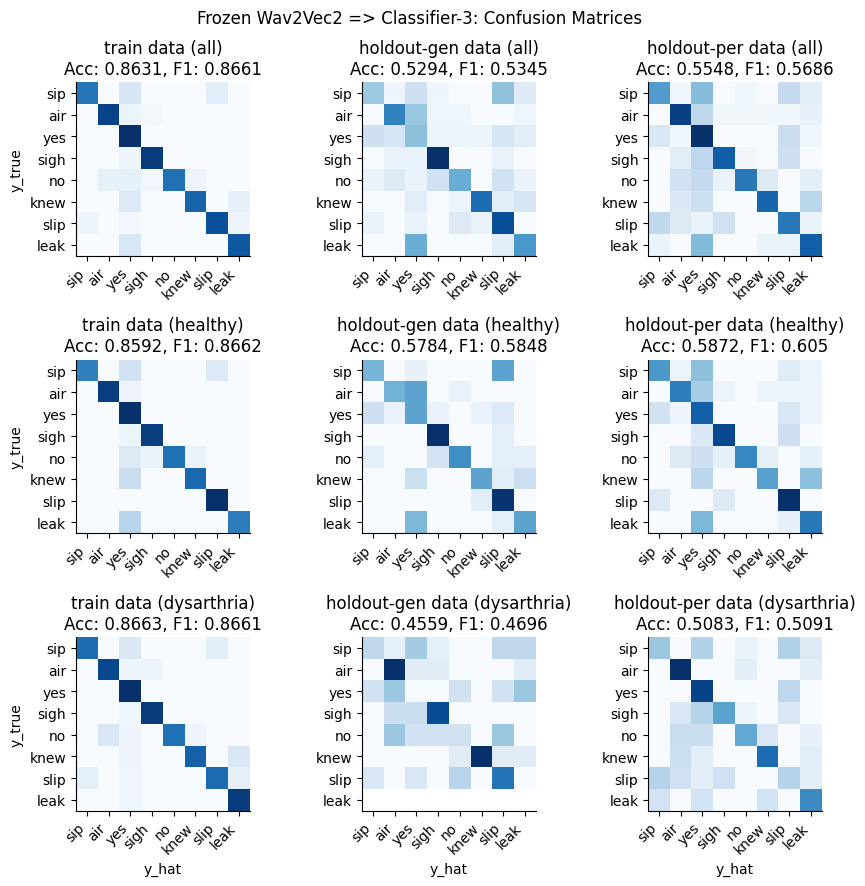

In [ ]:
learning_rate = 0.003
l2_strength = 0.00001
hidden_size_d1 = 64

n_epochs = 50

print(f"Best Hyperparameters: Learning Rate: {learning_rate}, Epochs: {n_epochs}, l2 reg: {l2_strength}")

df_list = []
for ii in range(3):
    itr_val = str(ii+1)
    seed_val = [100,200,300][ii]
    print(f"Run #{itr_val}: Seed={seed_val}")
    # Set Seed
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_val)

    tf.keras.backend.clear_session()

    # 1. Set up Model.
    input_dim = X_train_embeddings.shape[-1]
    num_classes = len(np.unique(y_tr))
    model = create_dense_model(input_dim, num_classes, l2_strength, hidden_size_d1)
    model.summary()
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    # 2. Fit Model.
    history = model.fit(X_train_embeddings, y_tr,
                        epochs=50,
                        callbacks=[early_stopping],
                        verbose=0, batch_size=16)
    # 3. Calcs
    y_hat_tr = np.argmax(model.predict(X_train_embeddings),axis=1)
    y_hat_tr_dys = y_hat_tr[df_train['speech_status']=="dysarthria"]
    y_hat_tr_non_dys = y_hat_tr[df_train['speech_status']=="healthy"]
    y_hat_gen = np.argmax(model.predict(X_h_gen_embeddings),axis=1)
    y_hat_gen_dys = y_hat_gen[df_test_gen['speech_status']=="dysarthria"]
    y_hat_gen_non_dys = y_hat_gen[df_test_gen['speech_status']=="healthy"]
    y_hat_per = np.argmax(model.predict(X_h_per_embeddings),axis=1)
    y_hat_per_dys = y_hat_per[df_test_per['speech_status']=="dysarthria"]
    y_hat_per_non_dys = y_hat_per[df_test_per['speech_status']=="healthy"]

    # Get ground truth subsets
    y_tr_dys = y_tr[df_train['speech_status'] == 'dysarthria']
    y_tr_non_dys = y_tr[df_train['speech_status'] == 'healthy']
    y_gen_dys = y_gen[df_test_gen['speech_status'] == 'dysarthria']
    y_gen_non_dys = y_gen[df_test_gen['speech_status'] == 'healthy']
    y_per_dys = y_per[df_test_per['speech_status'] == 'dysarthria']
    y_per_non_dys = y_per[df_test_per['speech_status'] == 'healthy']

    # Accuracy scores
    acc_tr = accuracy_score(y_tr, y_hat_tr)
    acc_tr_dys = accuracy_score(y_tr_dys, y_hat_tr_dys)
    acc_tr_non_dys = accuracy_score(y_tr_non_dys, y_hat_tr_non_dys)
    acc_gen = accuracy_score(y_gen, y_hat_gen)
    acc_gen_dys = accuracy_score(y_gen_dys, y_hat_gen_dys)
    acc_gen_non_dys = accuracy_score(y_gen_non_dys, y_hat_gen_non_dys)
    acc_per = accuracy_score(y_per, y_hat_per)
    acc_per_dys = accuracy_score(y_per_dys, y_hat_per_dys)
    acc_per_non_dys = accuracy_score(y_per_non_dys, y_hat_per_non_dys)

    # F1 scores
    f1_tr = f1_score(y_tr, y_hat_tr, average="weighted")
    f1_tr_dys = f1_score(y_tr_dys, y_hat_tr_dys, average="weighted")
    f1_tr_non_dys = f1_score(y_tr_non_dys, y_hat_tr_non_dys, average="weighted")
    f1_gen = f1_score(y_gen, y_hat_gen, average="weighted")
    f1_gen_dys = f1_score(y_gen_dys, y_hat_gen_dys, average="weighted")
    f1_gen_non_dys = f1_score(y_gen_non_dys, y_hat_gen_non_dys, average="weighted")
    f1_per = f1_score(y_per, y_hat_per, average="weighted")
    f1_per_dys = f1_score(y_per_dys, y_hat_per_dys, average="weighted")
    f1_per_non_dys = f1_score(y_per_non_dys, y_hat_per_non_dys, average="weighted")

    df_tr_data = pd.DataFrame({'y_true': y_tr,'y_hat': y_hat_tr,'status':df_train['speech_status'].values,'d_type':'train'})
    df_tr_data2 = pd.DataFrame({'y_true': y_tr,'y_hat': y_hat_tr,'status':'all','d_type':'train'})
    df_gen_data = pd.DataFrame({'y_true': y_gen,'y_hat': y_hat_gen,'status':df_test_gen['speech_status'].values,'d_type':'holdout-gen'})
    df_gen_data2 = pd.DataFrame({'y_true': y_gen,'y_hat': y_hat_gen,'status':'all','d_type':'holdout-gen'})
    df_per_data = pd.DataFrame({'y_true': y_per,'y_hat': y_hat_per,'status':df_test_per['speech_status'].values,'d_type':'holdout-per'})
    df_per_data2 = pd.DataFrame({'y_true': y_per,'y_hat': y_hat_per,'status':'all','d_type':'holdout-per'})
    df_b2 = pd.concat([df_tr_data, df_tr_data2, df_gen_data, df_gen_data2, df_per_data,df_per_data2])
    df_b2['y_true'] = label_encoder.inverse_transform(df_b2['y_true'])
    df_b2['y_hat'] = label_encoder.inverse_transform(df_b2['y_hat'])
    eval_embeddings_cm(df_b2,model_type="1",itr_type=itr_val)


    df_table = pd.DataFrame({
        'status': ['All','Healthy','Dysarthria'],
        'train':[f1_tr,f1_tr_non_dys,f1_tr_dys],
        'gen':[f1_gen,f1_gen_non_dys,f1_gen_dys],
        'per':[f1_per,f1_per_non_dys,f1_per_dys],
    })
    df_table['seed'] = seed_val
    df_list.append(df_table)

df_table = pd.concat(df_list)

| Dataset      | Subset     | Accuracy     | F1-Score  |
|--------------|------------|--------------|-----------|
| **Train**   | All        | 0.8567       | 0.8562        |
|            | Dysarthria | 0.8663       | 0.8643   |
|              | Healthy    | 0.8451       | 0.8427     |
| **Hold-Gen** | All        | 0.5529       | 0.5342     |
|              | Dysarthria | 0.4412       | 0.4307     |
|              | Healthy    | 0.6275       | 0.6156     |
| **Hold-Per** | All        | 0.5377       | 0.5322     |
|              | Dysarthria | 0.4       | 0.3852     |
|              | Healthy    | 0.6337       | 0.6344     |

## Baseline 3: Cold Wav2Vec2 => Conv1D

This model uses the unpooled embeddings.

In [ ]:
unpooled_embedding_matrix = np.concatenate(unpooled_embedding_list)
print(unpooled_embedding_matrix.shape)

(776, 187, 768)


### Extract Data for Conv1D

In [ ]:
label_encoder = LabelEncoder()

# load df_train
df_train = pd.read_csv("/content/drive/MyDrive/torgo_data/train_data.csv")
df_test_gen = pd.read_csv("/content/drive/MyDrive/torgo_data/holdout_gen.csv")
df_test_per = pd.read_csv("/content/drive/MyDrive/torgo_data/holdout_per.csv")

# Get Embeddings
X_train_embeddings = unpooled_embedding_matrix[[(x in set(df_train['path'])) for x in path_list]]
print(f"X_train_embeddings: {X_train_embeddings.shape}")
X_h_gen_embeddings = unpooled_embedding_matrix[[(x in set(df_test_gen['path'])) for x in path_list]]
print(f"X_h_gen_embeddings: {X_h_gen_embeddings.shape}")
X_h_per_embeddings = unpooled_embedding_matrix[[(x in set(df_test_per['path'])) for x in path_list]]
print(f"X_h_per_embeddings: {X_h_per_embeddings.shape}")

# Get Path IDs.
paths_tr = [x for x in path_list if x in set(df_train['path'])]
paths_h_gen = [x for x in path_list if x in set(df_test_gen['path'])]
paths_h_per = [x for x in path_list if x in set(df_test_per['path'])]

# Set as Index
df_train.set_index('path',inplace=True)
df_test_gen.set_index('path',inplace=True)
df_test_per.set_index('path',inplace=True)

# Get labels
y_tr = df_train.loc[paths_tr]['transcription']
y_tr = label_encoder.fit_transform(y_tr)
y_gen = df_test_gen.loc[paths_h_gen]['transcription']
y_gen = label_encoder.transform(y_gen)
y_per = df_test_per.loc[paths_h_per]['transcription']
y_per = label_encoder.transform(y_per)

print()
print(f"Classes: {label_encoder.classes_}")
print()
print(f"y_tr: {y_tr.shape} {y_tr[0:5]}...")
print(f"y_gen: {y_gen.shape} {y_gen[0:5]}...")
print(f"y_per: {y_per.shape} {y_per[0:5]}...")

# Get Speaker Status
status_tr = df_train.loc[paths_tr]['speech_status']
status_gen = df_test_gen.loc[paths_h_gen]['speech_status']
status_per = df_test_per.loc[paths_h_per]['speech_status']

# Get Speaker ID
speaker_tr = df_train.loc[paths_tr]['speaker_id']
speaker_gen = df_test_gen.loc[paths_h_gen]['speaker_id']
speaker_per = df_test_per.loc[paths_h_per]['speaker_id']

X_train_embeddings: (314, 187, 768)
X_h_gen_embeddings: (170, 187, 768)
X_h_per_embeddings: (292, 187, 768)

Classes: ['air' 'knew' 'leak' 'no' 'sigh' 'sip' 'slip' 'yes']

y_tr: (314,) [5 0 7 4 5]...
y_gen: (170,) [5 4 6 0 0]...
y_per: (292,) [1 7 5 4 6]...


In [ ]:

from sklearn.metrics import f1_score
from keras.callbacks import Callback
import numpy as np
import tensorflow as tf
import torch
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# define conv1d model.
def create_conv1d_classifier(input_shape, num_classes,l2_strength):
    input_tensor = keras.Input(shape=input_shape)
    x = layers.Conv1D(filters=64, kernel_size=3, activation='relu')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(filters=128, kernel_size=3, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu',kernel_regularizer=keras.regularizers.L2(l2_strength))(x)
    output_tensor = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=input_tensor, outputs=output_tensor)
    return model

# set up hyperparameter search
def run_model_conv_hyper(X, y, learning_rate, l2_strength, seedval=42, n_splits=3, n_epochs=50):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seedval)

    input_shape = X.shape[-2:]  # (time_steps, embedding_dim)
    num_classes = int(np.max(y)) + 1
    results = []

    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        print(f"Fold: {fold}")
        tf.keras.backend.clear_session()
        random.seed(seedval)
        np.random.seed(seedval)
        torch.manual_seed(seedval)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seedval)

        X_tr, X_val = X[train_index], X[val_index]
        y_tr, y_val = y[train_index], y[val_index]

        model = create_conv1d_classifier(input_shape, num_classes, l2_strength)
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

        early_stopping = EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True
        )

        model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        model.fit(X_tr, y_tr,
                  validation_data=(X_val, y_val),
                  epochs=n_epochs,
                  callbacks=[early_stopping],
                  verbose=0)

        y_hat_tr = np.argmax(model.predict(X_tr), axis=1)
        y_hat_val = np.argmax(model.predict(X_val), axis=1)

        results.append({
            'fold': fold,
            'lr': learning_rate,
            'l2_strength': l2_strength,
            'train_accuracy': accuracy_score(y_tr, y_hat_tr),
            'val_accuracy': accuracy_score(y_val, y_hat_val),
            'train_f1': f1_score(y_tr, y_hat_tr, average='weighted'),
            'val_f1': f1_score(y_val, y_hat_val, average='weighted'),
        })
    return pd.DataFrame(results)

def run_model_conv_eval(X_tr, y_tr, s_tr,
                        X_gen, y_gen, s_gen,
                        X_per, y_per, s_per,
                        learning_rate, l2_strength,
                        n_epochs, seedval):
    # 0. Housework
    tf.keras.backend.clear_session()
    # Assuming 'unpooled_train_embeddings' has shape (num_samples, time_steps, embedding_dim)
    input_shape = X_tr.shape[-2:] # (time_steps, embedding_dim)
    # unique classes is unique values of y_tr
    num_classes = int(max(y_tr)+1)
    # set seed
    random.seed(seedval)
    np.random.seed(seedval)
    torch.manual_seed(seedval)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seedval)

    # 1. Create the model
    conv1d_model = create_conv1d_classifier(input_shape, num_classes,l2_strength)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # Early Stopping Callback
    early_stopping = EarlyStopping(
        monitor='val_accuracy',  # Metric to monitor
        patience=10,             # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
    )

    conv1d_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # 2. Fit Model.
    history = conv1d_model.fit(X_tr, y_tr,
                              epochs=n_epochs,
                              validation_split=0.20,
                              callbacks=[early_stopping])

    # 3. predict on train/gen/per
    print()
    print(f"X_t: {X_tr.shape}")
    y_hat_tr  = conv1d_model.predict(X_tr)
    y_hat_tr = np.argmax(y_hat_tr,axis=1)
    print(f"y_t: {y_hat_tr.shape}")

    print()
    print(f"X_gen: {X_gen.shape}")
    y_hat_gen  = conv1d_model.predict(X_gen)
    y_hat_gen = np.argmax(y_hat_gen,axis=1)
    print(f"y_gen: {y_hat_gen.shape}")

    print()
    print(f"X_per: {X_per.shape}")
    y_hat_per  = conv1d_model.predict(X_per)
    y_hat_per = np.argmax(y_hat_per,axis=1)
    print(f"y_per: {y_hat_per.shape}")
    df_results_tr = pd.DataFrame({
        'y_true': y_tr,
        'y_hat': y_hat_tr,
        'status': s_tr,
        'd_type': 'train'
    })
    df_results_gen = pd.DataFrame({
        'y_true': y_gen,
        'y_hat': y_hat_gen,
        'status': s_gen,
        'd_type': 'holdout-gen'
    })
    df_results_per = pd.DataFrame({
        'y_true': y_per,
        'y_hat': y_hat_per,
        'status': s_per,
        'd_type': 'holdout-per'
    })
    df_results = pd.concat([df_results_tr, df_results_gen, df_results_per])
    return df_results, history


Hyperparameter training

In [ ]:
df_hyper = pd.DataFrame()
for l2_strength in [1e-3,1e-4,1e-5]:
  for learning_rate in [1e-3,1e-4,1e-5]:
    print(f"{l2_strength} {learning_rate}")
    # Run the conv1d model w/ the seed.
    df_temp = run_model_conv_hyper(
                X_train_embeddings, y_tr,
                learning_rate, l2_strength)
    df_hyper = pd.concat([df_hyper,df_temp])
df_hyper.head()

0.001 0.001
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
0.001 0.0001
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
0.001 1e-05
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
0.0001 0.001
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
0.0001 0.0001
7/7 ━━━━━━━━━━━━━━━━━━━━

,fold,lr,l2_strength,train_accuracy,val_accuracy,train_f1,val_f1
0,0,0.0010,0.001,0.976077,0.704762,0.976072,0.700419
1,1,0.0010,0.001,0.904306,0.628571,0.903096,0.630426
2,2,0.0010,0.001,0.990476,0.778846,0.990469,0.775522
0,0,0.0001,0.001,0.488038,0.295238,0.467092,0.282733
1,1,0.0001,0.001,0.851675,0.371429,0.849807,0.371376


In [ ]:
df_hyper.groupby(['l2_strength','lr']).mean().reset_index().sort_values('val_accuracy',ascending=False)

,l2_strength,lr,fold,train_accuracy,val_accuracy,train_f1,val_f1
5,0.00010,0.00100,1.0,0.977702,0.729335,0.977876,0.725526
2,0.00001,0.00100,1.0,0.974512,0.722955,0.974729,0.724803
8,0.00100,0.00100,1.0,0.956953,0.704060,0.956546,0.702122
1,0.00001,0.00010,1.0,0.684492,0.376007,0.673417,0.366381
4,0.00010,0.00010,1.0,0.667191,0.369383,0.660360,0.352440
7,0.00100,0.00010,1.0,0.710063,0.347222,0.701239,0.344502
6,0.00100,0.00001,1.0,0.130630,0.149573,0.100681,0.120744
3,0.00010,0.00001,1.0,0.151325,0.146429,0.122892,0.122281
0,0.00001,0.00001,1.0,0.127417,0.143254,0.104170,0.116605


So, the best performing hyperparameter is lr=1e-3, l2=1e-4

In [ ]:
def plot_model_itr_history(history_dict, df_performace, model_n, itr_n):
    df_to_plot_tr = pd.DataFrame(data={
        'loss':history_dict.history['loss'],
        'acc':history_dict.history['accuracy'],
        'epoch':np.arange(1,len(history_dict.history['loss'])+1),
        'type':'train'
    })
    df_to_plot_val = pd.DataFrame(data={
        'loss':history_dict.history['val_loss'],
        'acc':history_dict.history['val_accuracy'],
        'epoch':np.arange(1,len(history_dict.history['val_loss'])+1),
        'type':'val'
    })
    df_to_plot = pd.concat([df_to_plot_tr,df_to_plot_val])
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    sns_loss = sns.lineplot(
        data=df_to_plot,
        x='epoch',
        y='loss',
        hue='type',
        markers=True,      # optional
        dashes=True,       # optional
        ax=axs[0]
    )

    # Get color mapping from the loss plot
    handles, labels = sns_loss.get_legend_handles_labels()
    color_dict_loss = dict(zip(labels, [h.get_color() for h in handles]))

    sns_acc = sns.lineplot(
        data=df_to_plot,
        x='epoch',
        y='acc',
        hue='type',
        markers=True,      # optional
        dashes=True,       # optional
        ax=axs[1]
    )

    # Get color mapping from the acc plot
    handles, labels = sns_acc.get_legend_handles_labels()
    color_dict_acc = dict(zip(labels, [h.get_color() for h in handles]))

    # Get current handles and labels
    handles, labels = axs[1].get_legend_handles_labels()

    # Map original metric labels to custom names
    label_map = {
        'train': '80% Training Data',
        'val': '20% Validation',
    }

    # Update labels, keeping 'stage' labels as-is
    new_labels = [label_map.get(label, label) for label in labels]

    # Set the updated legend

    axs[0].legend(handles=handles, labels=new_labels, title='Metric')
    axs[1].legend(handles=handles, labels=new_labels, title='Metric')

    # set supertitle
    axs[0].set_title('Loss per Epoch')
    axs[1].set_title('Accuracy per Epoch')

    axs[0].set_xlabel('Epoch')
    axs[1].set_xlabel('Epoch')
    axs[0].set_ylabel('Categorical Cross-Entropy Loss')
    axs[1].set_ylabel('Accuracy Score')

    # set supertitle
    plt.suptitle(f"Model {model_detail_dict[model_n]} Performance During Training\n Final Acc. of Run #{itr_n} Marked as Train-Blue, Per-Geen, Gen-Red")
    plt.tight_layout()

    # Get color mapping from the loss plot
    handles, labels = sns_loss.get_legend_handles_labels()
    color_dict_loss = dict(zip(labels, [h.get_color() for h in handles]))


    # Finishing up. Get accuracies from df_c
    final_tr_acc = accuracy_score(df_concat[df_concat['d_type']=="train"]['y_true'], df_concat[df_concat['d_type']=="train"]['y_hat'])
    final_gen_acc = accuracy_score(df_concat[df_concat['d_type']=="holdout-gen"]['y_true'], df_concat[df_concat['d_type']=="holdout-gen"]['y_hat'])
    final_per_acc = accuracy_score(df_concat[df_concat['d_type']=="holdout-per"]['y_true'], df_concat[df_concat['d_type']=="holdout-per"]['y_hat'])

    # ???? plot a point on the accuracy_per_epoch to mark the final results.
    axs[1].plot(len(history_dict.history['loss'])+1, final_tr_acc, 'bp', label='Final Train Acc.')
    axs[1].plot(len(history_dict.history['loss'])+1, final_gen_acc, 'rp', label='Final Holdout-Gen Acc.')
    axs[1].plot(len(history_dict.history['loss'])+1, final_per_acc, 'gp', label='Final Holdout-Per Acc.')
    axs[1].legend()

    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/torgo_data/BS_M{model_n}_I{itr_n}_loss_acc.png', dpi=300)
    plt.show()


ITR 1, seed 100
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 750ms/step - accuracy: 0.1309 - loss: 5.5643 - val_accuracy: 0.1429 - val_loss: 2.0520
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1610 - loss: 3.5479 - val_accuracy: 0.2063 - val_loss: 1.9960
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1790 - loss: 3.1267 - val_accuracy: 0.3175 - val_loss: 1.9738
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2245 - loss: 2.4694 - val_accuracy: 0.3016 - val_loss: 1.9616
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2628 - loss: 2.4109 - val_accuracy: 0.2381 - val_loss: 1.9652
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2428 - loss: 2.3900 - val_accuracy: 0.2698 - val_loss: 1.9281
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2318 - loss: 2.2762 - val_accuracy: 0.3016 - val_loss: 1.8935
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2964 - loss: 2.0988 - val_accuracy: 0.2381 -

<ipython-input-5-cea9a18bf40d>:108: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<Figure size 1500x1500 with 0 Axes>

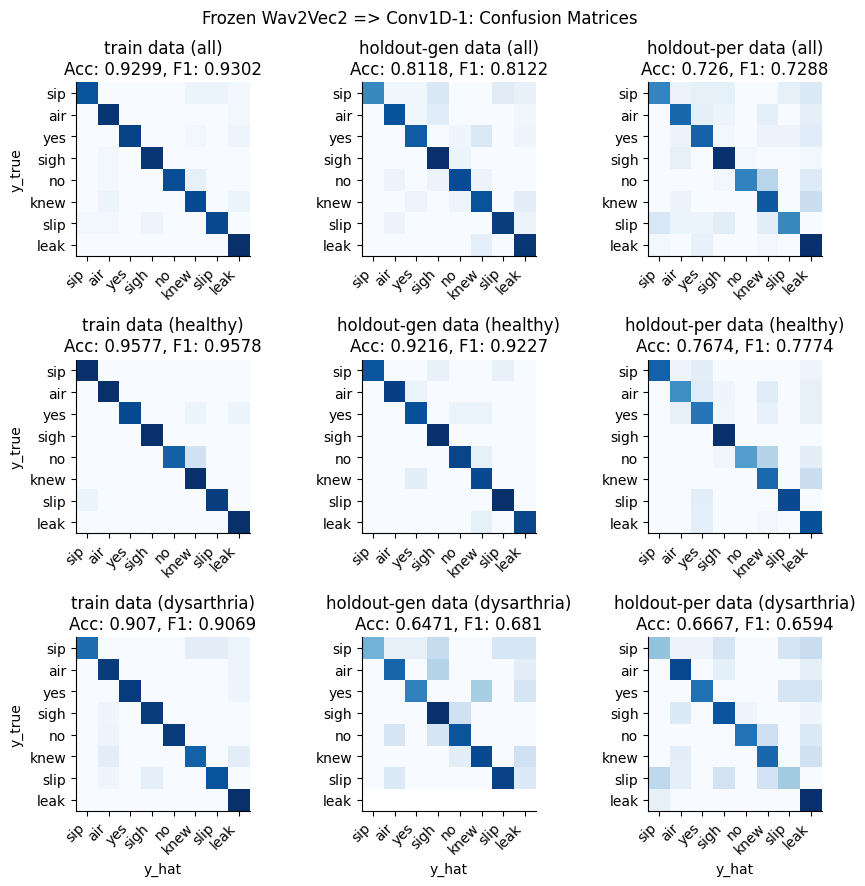

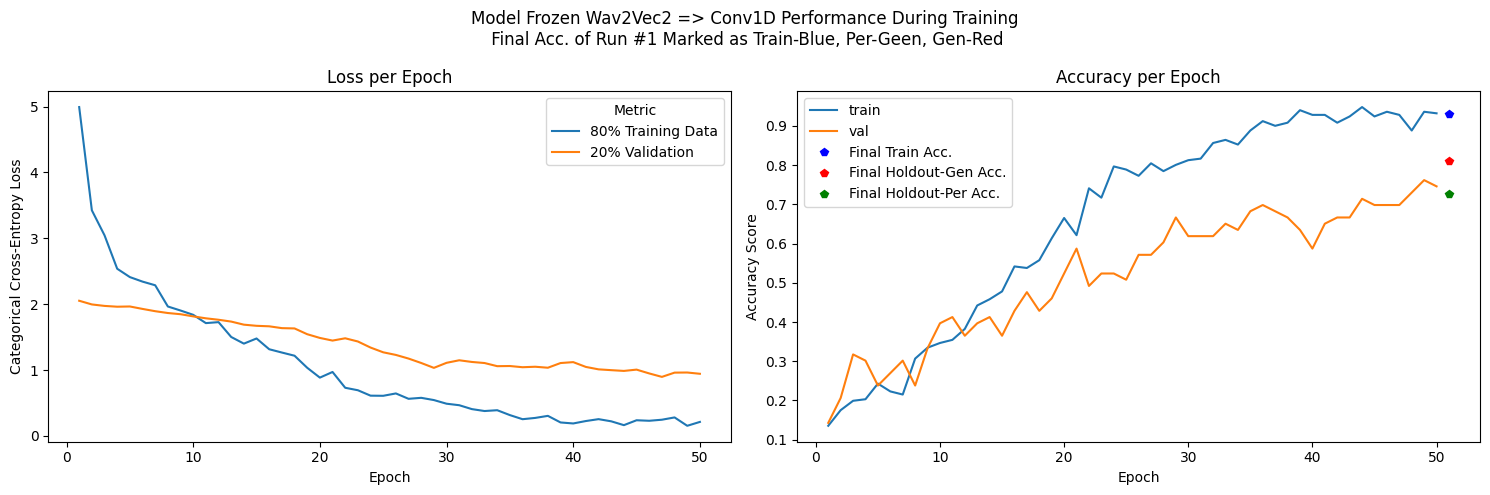

ITR 2, seed 200
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 504ms/step - accuracy: 0.1186 - loss: 5.1350 - val_accuracy: 0.1270 - val_loss: 2.1228
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.1682 - loss: 3.4655 - val_accuracy: 0.1587 - val_loss: 2.0743
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2391 - loss: 2.6860 - val_accuracy: 0.1905 - val_loss: 2.0614
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2539 - loss: 2.2805 - val_accuracy: 0.2222 - val_loss: 2.0324
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2418 - loss: 2.1115 - val_accuracy: 0.2222 - val_loss: 1.9876
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3109 - loss: 2.0311 - val_accuracy: 0.2540 - val_loss: 1.9787
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2778 - loss: 2.1594 - val_accuracy: 0.2698 - val_loss: 1.9631
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2787 - loss: 2.2023 - val_accuracy: 0.3016 - 

<ipython-input-5-cea9a18bf40d>:108: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<Figure size 1500x1500 with 0 Axes>

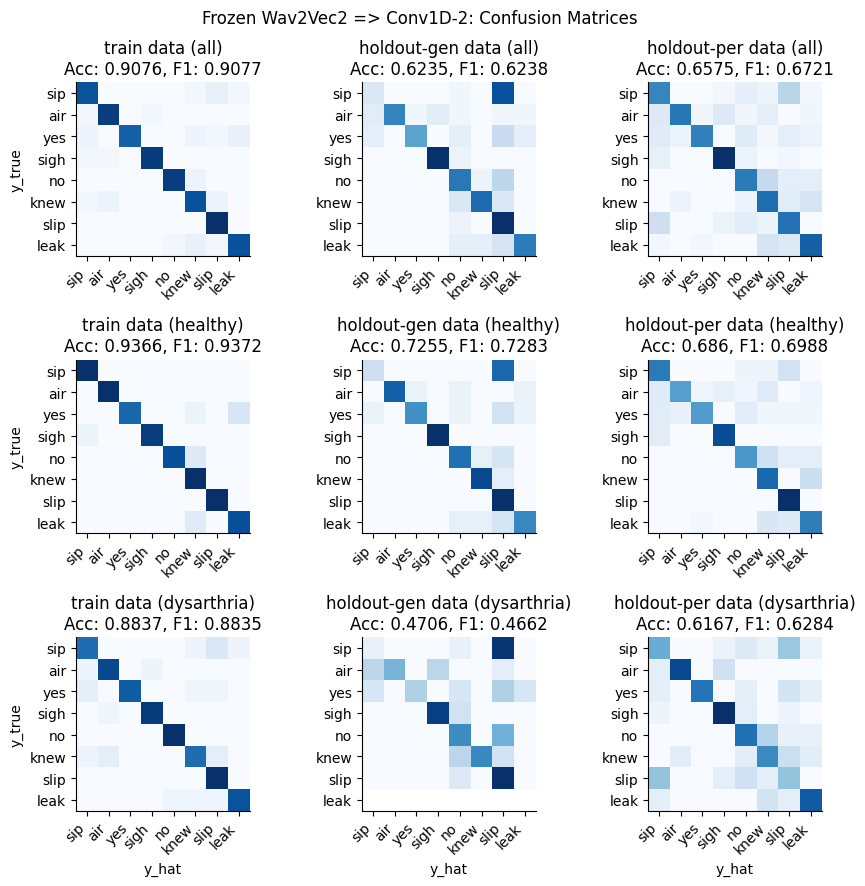

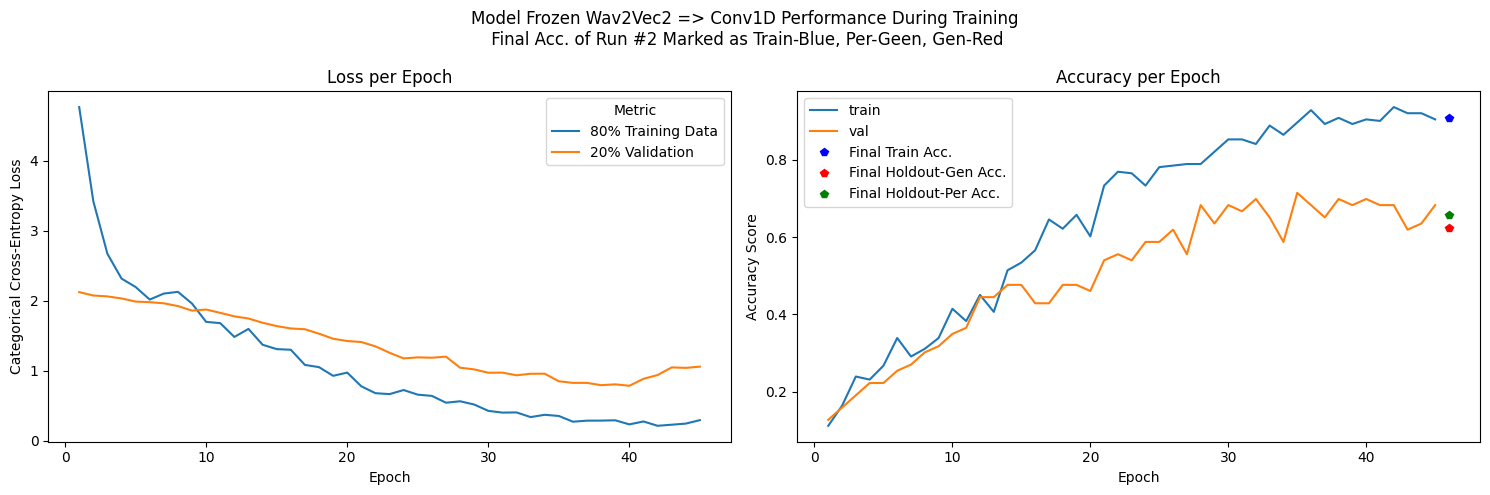

ITR 3, seed 300
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 633ms/step - accuracy: 0.1410 - loss: 7.8435 - val_accuracy: 0.1270 - val_loss: 2.1205
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1964 - loss: 3.7008 - val_accuracy: 0.1111 - val_loss: 2.1117
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.1370 - loss: 3.1692 - val_accuracy: 0.1587 - val_loss: 2.0822
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.2407 - loss: 2.6700 - val_accuracy: 0.1429 - val_loss: 2.0512
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.2605 - loss: 2.3867 - val_accuracy: 0.1587 - val_loss: 2.0221
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3081 - loss: 2.1821 - val_accuracy: 0.1587 - val_loss: 1.9901
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.2500 - loss: 2.2607 - val_accuracy: 0.2698 - val_loss: 1.9520
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3379 - loss: 2.0010 - val_accuracy: 0.2540 -

<ipython-input-5-cea9a18bf40d>:108: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<Figure size 1500x1500 with 0 Axes>

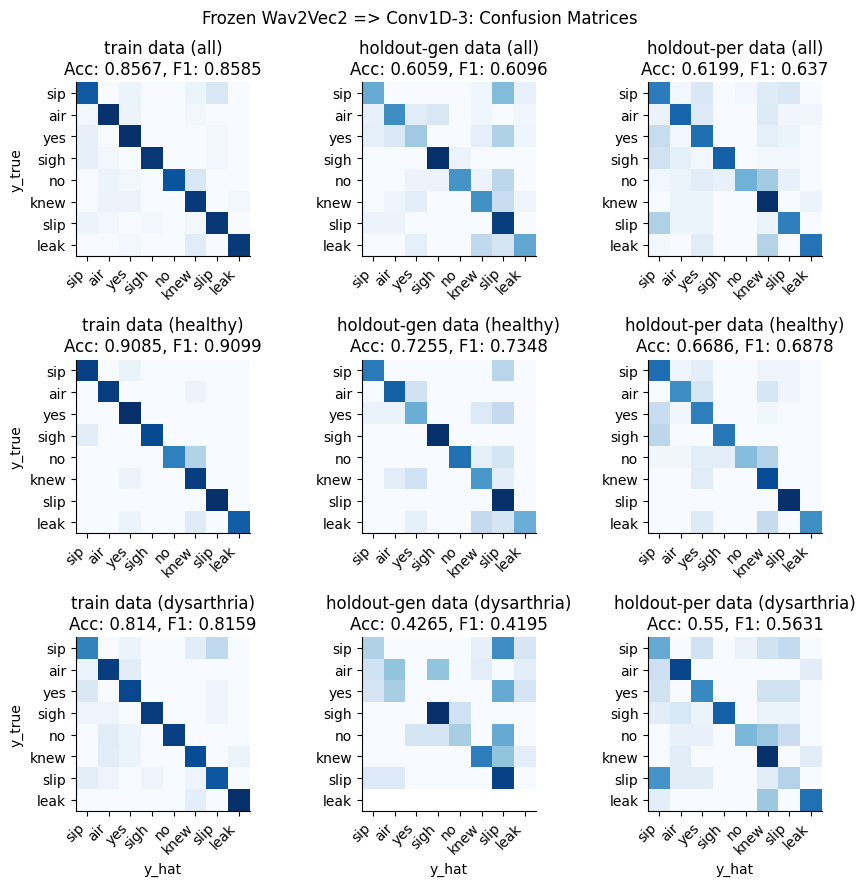

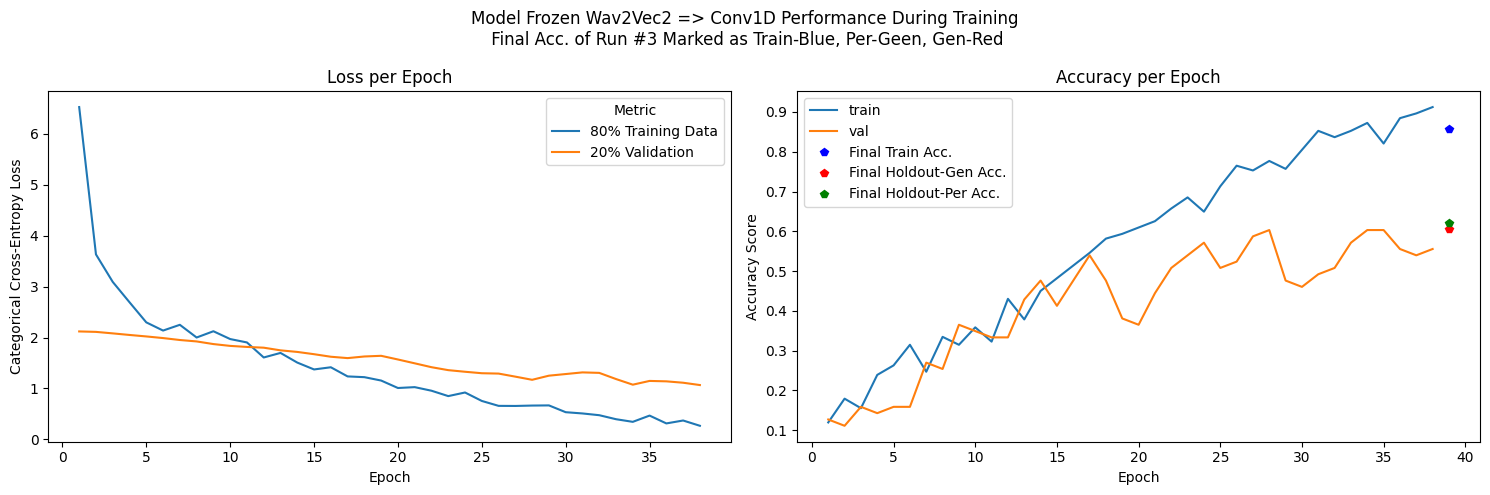

In [ ]:
df_collector = pd.DataFrame()
df_list = []
for ii in range(3):
    itr_val = str(ii+1)
    seed_val = [100,200,300][ii]
    print(f"ITR {itr_val}, seed {seed_val}")

    # Run the conv1d model w/ the seed.
    df_concat, history_dict = run_model_conv_eval(
                X_train_embeddings, y_tr, status_tr,
                X_h_gen_embeddings, y_gen, status_gen,
                X_h_per_embeddings, y_per, status_per,
                learning_rate=1e-3, l2_strength=1e-4,
                n_epochs=50, seedval=seed_val)

    # restore labels.
    df_concat = df_concat.reset_index()
    df_concat['y_true'] = label_encoder.inverse_transform(df_concat['y_true'])
    df_concat['y_hat'] = label_encoder.inverse_transform(df_concat['y_hat'])
    df_concat['seed']= seed_val
    df_list.append(df_concat)
    # plot cm.
    eval_embeddings_cm(df_concat,model_type="2",itr_type=itr_val)
    plot_model_itr_history(history_dict, df_concat, "2",itr_val)

df_concat = pd.concat(df_list)

In [ ]:
valid_words = list(set(df_concat['y_true']).union(set(df_concat['y_hat'])))
print(valid_words)

for seed in [100,200,300]:
  for status in ['all','healthy','dysarthria']:
    if status == 'all':
      df_temp = df_concat[(df_concat['seed']==seed)]
    else:
      df_temp = df_concat[(df_concat['seed']==seed) & (df_concat['status']==status)]
    label_encoder = LabelEncoder()
    label_encoder.fit(valid_words)

    y_tr = df_temp[df_temp['d_type']=="train"]['y_true']
    y_tr = label_encoder.transform(y_tr)
    y_hat_tr = df_temp[df_temp['d_type']=="train"]['y_hat']
    y_hat_tr = label_encoder.transform(y_hat_tr)
    f1_tr = f1_score(df_temp[df_temp['d_type']=="train"]['y_true'], df_temp[df_temp['d_type']=="train"]['y_hat'], average='weighted')
    f1_gen = f1_score(df_temp[df_temp['d_type']=="holdout-gen"]['y_true'], df_temp[df_temp['d_type']=="holdout-gen"]['y_hat'], average='weighted')
    f1_per = f1_score(df_temp[df_temp['d_type']=="holdout-per"]['y_true'], df_temp[df_temp['d_type']=="holdout-per"]['y_hat'], average='weighted')
    if status == 'all':
      print(r"\multirow{3}{*}{\textbf{"+str(seed)+r"}} & "+status.capitalize()+f" & {round(f1_tr,4)} & {round(f1_gen,4)} & {round(f1_per,4)}" + r" \\")
    else:
      print(r"& "+status.capitalize()+f" & {round(f1_tr,4)} & {round(f1_gen,4)} & {round(f1_per,4)}" + r" \\")

['sigh', 'leak', 'slip', 'sip', 'air', 'knew', 'no', 'yes']
\multirow{3}{*}{\textbf{100}} & All & 0.9302 & 0.8122 & 0.7288 \\
& Healthy & 0.9578 & 0.9227 & 0.7774 \\
& Dysarthria & 0.9069 & 0.681 & 0.6594 \\
\multirow{3}{*}{\textbf{200}} & All & 0.9077 & 0.6238 & 0.6721 \\
& Healthy & 0.9372 & 0.7283 & 0.6988 \\
& Dysarthria & 0.8835 & 0.4662 & 0.6284 \\
\multirow{3}{*}{\textbf{300}} & All & 0.8585 & 0.6096 & 0.637 \\
& Healthy & 0.9099 & 0.7348 & 0.6878 \\
& Dysarthria & 0.8159 & 0.4195 & 0.5631 \\
